In [1]:
import xgboost as xgb
from utils import get_data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
def hrv_wrapper(window):
    # print(window['label'].max())
    # nn_intervals_list = [1000, 1050, 1020, 1080, ..., 1100, 1110, 1060]
    HR_interval = window['HR_interval']
    time_domain_features = get_time_domain_features(HR_interval)
    
    values = list(time_domain_features.values())
    index = list(time_domain_features.keys())
    
    frequency_domain_features = get_frequency_domain_features(HR_interval)
    
    values.extend(list(frequency_domain_features.values()))
    index.extend(list(frequency_domain_features.keys()))
    values.extend([window['itp_HR'].mean(), window['itp_RR'].mean(), window['itp_Temp'].mean(), window['itp_Po'].mean(), window['label'].max()])
    index.extend(['itp_HR', 'itp_RR', 'itp_Temp', 'itp_Po', 'label'])
    return pd.Series(values, index=index)

In [3]:
X = []
for i in range(1, 37):
    if i == 11: continue
    X.append(get_data(i)[1])
    

combined_df = pd.concat(X, ignore_index=True)

# combined_df.rolling(3000, step=1500).apply(hrv_wrapper, raw=False)
hrv_df = pd.DataFrame([hrv_wrapper(x) for x in combined_df.rolling(3000, step=1500, center=True)])
hrv_df
# X = np.vstack(X)
# y = X[:,-1]
# X = X[:, :-1]

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,lf_hf_ratio,lfnu,hfnu,total_power,vlf,itp_HR,itp_RR,itp_Temp,itp_Po,label
0,2954.167638,98.086492,1.603096,0.0,0.0,0.0,0.000000,1.607403,2944.609167,394.438333,...,267.040137,99.626922,0.373078,20.080388,19.660558,7.250058,1.811489,0.027931,-29.157543,0.0
1,2892.394726,251.084375,3.206436,0.0,0.0,0.0,0.000000,3.219813,2931.092500,1192.015000,...,207.925951,99.521362,0.478638,95.073950,92.843054,3.543684,1.197835,0.023955,-28.805694,1.0
2,2734.958068,315.352900,5.077816,0.0,0.0,0.0,0.000000,5.080804,2832.123333,1192.015000,...,251.267600,99.603596,0.396404,219.508441,211.910920,-5.902516,-2.308807,-0.004982,-27.385418,1.0
3,2504.671361,256.458777,5.015601,0.0,0.0,1.0,0.033344,5.015934,2466.057833,1130.076500,...,207.405969,99.520167,0.479833,234.966470,226.714187,-10.014718,-0.034230,0.012390,-26.122662,1.0
4,2177.344527,233.789046,3.053434,0.0,0.0,1.0,0.033344,3.057948,2114.926500,758.066333,...,137.600007,99.278499,0.721501,109.942203,106.297268,-7.154328,6.255587,0.050363,-27.728831,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,2080.848166,101.319877,2.225395,0.0,0.0,0.0,0.000000,2.227079,2072.217583,499.451167,...,235.454053,99.577085,0.422915,78.001374,76.317595,2.850890,9.190244,-0.001216,-30.138959,0.0
574,2037.561723,100.661609,2.182572,0.0,0.0,0.0,0.000000,2.182914,2007.468667,483.638667,...,226.693278,99.560813,0.439187,77.464390,75.816535,0.253703,13.927282,-0.000208,-30.412701,0.0
575,2021.824263,109.217609,2.056055,0.0,0.0,0.0,0.000000,2.056082,1970.600500,466.507667,...,222.969201,99.553510,0.446490,63.636470,61.622916,-0.690544,14.074758,0.001214,-30.474204,0.0
576,1988.029619,97.242848,1.800990,0.0,0.0,0.0,0.000000,1.802004,1956.299167,474.504667,...,215.434771,99.537967,0.462033,46.611171,44.799560,-2.718223,13.244701,-0.001452,-30.574450,0.0


In [4]:
# Selct all columns but lable for X
X = hrv_df.drop('label', axis=1).values
y = hrv_df['label'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, objective='binary:logistic')

In [7]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_pred = clf.predict(X_test)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       156
         1.0       0.31      0.23      0.26        35

    accuracy                           0.76       191
   macro avg       0.57      0.56      0.56       191
weighted avg       0.74      0.76      0.75       191



In [10]:
confusion_matrix(y_test, y_pred)

array([[138,  18],
       [ 27,   8]])

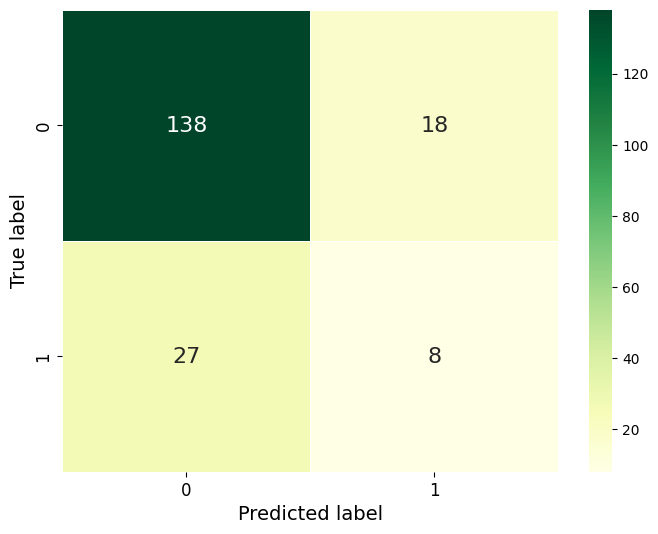

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix data
conf_matrix = np.array([[138, 18],
                        [27, 8]])

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with a larger font size for the annotations
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', linewidths=.5, annot_kws={"size": 16})

# Add labels and title with a larger font size
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
# plt.title('Confusion Matrix', fontsize=16)

# Increase the font size of the axis tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()
